# Consistency training

In [ ]:
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, seaborn as sns, copy, re
from pathlib import Path
from functools import partial
import fastcore.all as fc
from torch import tensor, nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from datasets import load_dataset
import torchvision.transforms.functional as TF
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from diffusers import UNet2DModel
from accelerate import Accelerator
from fastprogress import progress_bar
import fastcore.all as fc

from miniai.core import *
from miniai.resnet import *
from miniai.datasets import *
from miniai.accel import *
from miniai.learner import *

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [ ]:
from consistency import ConsistencyCB
from loss import LPIPS
from model import ConsistencyModel

In [ ]:
import timm

vgg = timm.create_model('vgg16', pretrained=True).features.to('cuda:1')

#### Initialise from random

First, I'll try consistency training without initialising from a pretrained model.

In [ ]:
model = ConsistencyModel(in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 768))

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
# change batch size if you're working with a small GPU - there are up to 4 models in memory at one time (teacher, online, online_ema, vgg)
# this fits on one 48GB GPU
bs = 96
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
lr, epochs = 4e-5, 20
steps = epochs*len(dls.train)
scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, total_steps=steps, max_lr=lr))
consistency = ConsistencyCB(training_mode='training', use_ema=True, mu0=0.9, device='cuda:1')
cbs = [DeviceCB(device='cuda:1'), MetricsCB(), ProgressCB(plot=True), consistency]
loss = LPIPS(vgg, device='cuda:1')
learn = Learner(dls, model, cbs=cbs, scheduler=scheduler, loss_func=loss, opt_func=partial(optim.Adam, eps=1e-5))

loss,epoch,train
6.046,0,train
3.289,0,eval
2.550,1,train
1.830,1,eval
1.640,2,train
1.392,2,eval
1.336,3,train
1.259,3,eval
1.149,4,train
1.055,4,eval


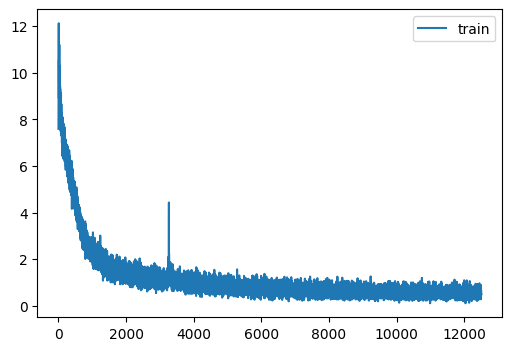

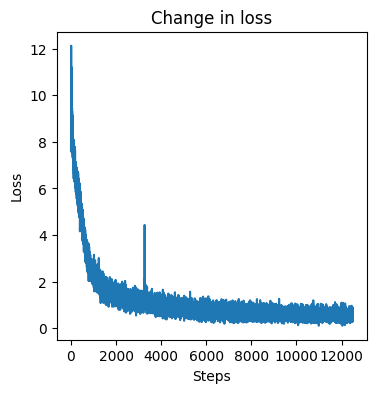

In [ ]:
learn.fit(lr, epochs)

In [ ]:
torch.save(consistency.online_ema, '/home/models/consistency_train_big.pkl')

In [ ]:
from sample import consistency_sample, karras_sample, heun
from karras import sigmas_karras

In [ ]:
@torch.no_grad()
def consistency_sample(size, model, steps=100, device='cuda', sigma_min=2e-3, sigma_max=80., sigma_data=0.):
    x = torch.randn(size).to(device) * sigma_max
    sigma = sigmas_karras(steps).to(device)
    x = model((x, torch.tensor(sigma_max)), sigma_data=sigma_data)
    if steps <= 1: return x
    for t in progress_bar(range(steps-1)):
        z = torch.randn_like(x)
        xt = x + (sigma[t]**2 - sigma_min**2).sqrt()*z
        x = model((xt, (sigma[t]**2 - sigma_min**2).sqrt()), sigma_data=sigma_data)
    return x

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 2048
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from miniai.fid import FID
class_model = torch.load('/home/models/resnet_dataaug_20_2.pkl')
fidder = FID(dls, class_model, 5)

In [ ]:
consistency_model = torch.load('/home/models/consistency_train_big.pkl')

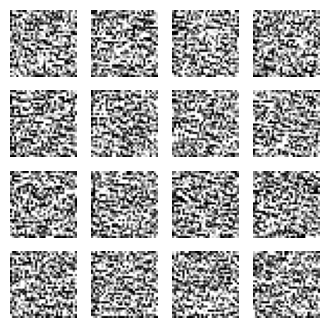

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=20, device='cuda:1', sigma_data=0.66)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

#### Initialise from pretrained

I'll try retraining again, but this time initialise the consistency model from a pretrained EDM model.

In [ ]:
from model import UNet

In [ ]:
model = ConsistencyModel(in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 768))
karras_model = torch.load('/home/models/karras_big_50.pkl')
model.load_state_dict(karras_model.state_dict())

<All keys matched successfully>

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
# change batch size if you're working with a small GPU - there are up to 4 models in memory at one time (teacher, online, online_ema, vgg)
# this fits on one 48GB GPU
bs = 96
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
lr, epochs = 4e-5, 20
steps = epochs*len(dls.train)
scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, total_steps=steps, max_lr=lr))
consistency = ConsistencyCB(training_mode='training', use_ema=True, mu0=0.9, device='cuda:1')
cbs = [DeviceCB(device='cuda:1'), MetricsCB(), ProgressCB(plot=True), consistency]
loss = LPIPS(vgg, device='cuda:1')
learn = Learner(dls, model, cbs=cbs, scheduler=scheduler, loss_func=loss, opt_func=partial(optim.Adam, eps=1e-5))

loss,epoch,train
3.741,0,train
1.873,0,eval
1.842,1,train
1.556,1,eval
1.457,2,train
1.332,2,eval
1.263,3,train
1.143,3,eval
1.086,4,train
0.999,4,eval


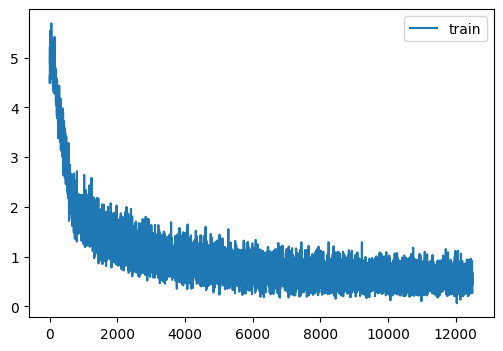

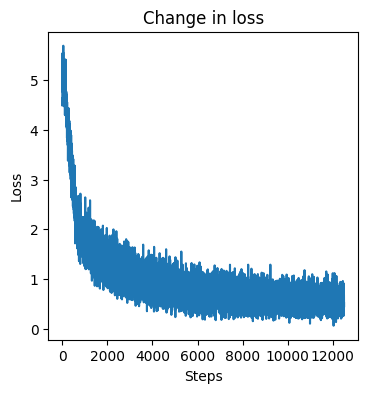

In [ ]:
learn.fit(lr, epochs)

In [ ]:
torch.save(consistency.online_ema, '/home/models/consistency_train_big_pre.pkl')

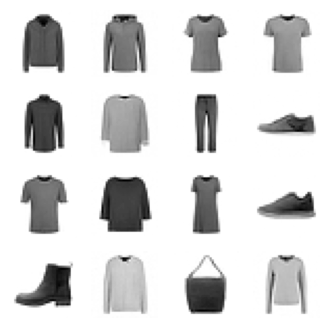

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency.online_ema, steps=20, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

10.766510009765625

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency.online_ema, steps=5, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)